In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# Program bar
from tqdm.auto import trange, tqdm

# jedi 0.14.1 tab completion fails; will be fixed in 0.14.2
import jedi
if jedi.__version__ == '0.14.1':
    %config Completer.use_jedi = False

In [3]:
import pynrc
from pynrc import nrc_utils
pynrc.setup_logging('WARN', verbose=True)

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [4]:
from pynrc.nrc_utils import (webbpsf, poppy, pix_noise, S)
from pynrc.reduce.ref_pixels import NRC_refs

In [5]:
from pynrc import speckle_noise as sn
from astropy.io import fits, ascii

In [6]:
from pynrc.nrc_utils import hist_indices, binned_statistic
from pynrc.nrc_utils import jl_poly_fit, jl_poly, pad_or_cut_to_size, rotate_offset

# Functions

In [7]:
# Pupil and segment information
pupil_file = webbpsf.utils.get_webbpsf_data_path() + "/jwst_pupil_RevW_npix1024.fits.gz"
pupil_hdul = fits.open(pupil_file)

segmap_file = webbpsf.utils.get_webbpsf_data_path() + "/JWpupil_segments.fits"
segmap_hdul = fits.open(segmap_file)

def segment_pupil_opd(hdu, segment_name):
    
    if segment_name.upper()=='ALL':
        opd_im, opd_header = (hdu.data, hdu.header)

        # New Pupil HDUList
        hdu = fits.PrimaryHDU(pupil_hdul[0].data)
        hdu.header = pupil_hdul[0].header.copy()
        pupil_all_hdul = fits.HDUList([hdu])
        
        # New OPD HDUList
        hdu = fits.PrimaryHDU(opd_im * pupil_all_hdul[0].data)
        hdu.header = opd_header.copy()
        opd_all_hdul = fits.HDUList([hdu])
        
        return (pupil_all_hdul, opd_all_hdul)

        
    # Parse out segment number
    segment_official_name = webbpsf.webbpsf_core.segname(segment_name)
    # Parse out the segment number
    num = int(segment_official_name.split('-')[1])
    # Index of segment to grab
    iseg = num - 1

    # Pupil mask of segment only
    pupil_seg_hdul = webbpsf.webbpsf_core.one_segment_pupil(segment_name)
    
    opd_im, opd_header = (hdu.data, hdu.header)
    opd_im_seg = opd_im * pupil_seg_hdul[0].data
    
    # New Pupil HDUList
    hdu = fits.PrimaryHDU(pupil_seg_hdul[0].data)
    hdu.header = pupil_seg_hdul[0].header.copy()
    pupil_seg_hdul = fits.HDUList([hdu])

    # New OPD HDUList
    hdu = fits.PrimaryHDU(opd_im_seg * pupil_seg_hdul[0].data)
    hdu.header = opd_header.copy()
    opd_seg_hdul = fits.HDUList([hdu])
    
    return (pupil_seg_hdul, opd_seg_hdul)

In [8]:
# Interpolate dark/bias at a given temperature

import os
def bias_dark(T=80):
    # Grab the appropriate dark ramp
    sca = 485
    dark_dir = 'NRC_80K/'
    dark_files = [f for f in os.listdir(dark_dir)]
    matching = [s for s in dark_files if (("_{}_".format(sca) in s) and (s.endswith(".fits")))]
    fname = dark_dir + matching[0]

    # Open the 80K dark fits
    hdul = fits.open(fname)

    header = hdul[0].header
    nint   = header['NINT']
    ng     = header['NGROUP']

    # Reference pixel correction
    data_mn = np.zeros([ng,2048,2048])
    for i in range(nint):
        data_int = hdul[0].data[i*ng:(i+1)*ng]
        ref = NRC_refs(data_int, header)
        ref.calc_avg_amps()
        ref.correct_amp_refs()

        data_mn += ref.data

    data_mn /= nint
    hdul.close()

    # Perform linear fit to averaged ramps
    det = ref.detector
    tarr = (np.arange(det.multiaccum.ngroup)+1) * det.time_group
    bias_80K, dark_80K = nrc_utils.jl_poly_fit(tarr, data_mn)
    
    file_dark0 = pynrc.conf.PYNRC_PATH + 'sca_images/SUPER_DARK_{}.FITS'.format(sca)
    file_bias0 = pynrc.conf.PYNRC_PATH + 'sca_images/SUPER_BIAS_{}.FITS'.format(sca)

    hdul_dark0 = fits.open(file_dark0)
    hdul_bias0 = fits.open(file_bias0)
    
    dark0 = hdul_dark0[0].data
    bias0 = hdul_bias0[0].data
    
    # Some interpolation (not necessarily true, but a guess)
    f = ((T-39.0) / (80.0-39.0))
    dark_new = (dark_80K*f**2 + dark0*(1-f**2))
    bias_new = (bias_80K*f + bias0*(1-f))
    
    hdul_dark0.close()
    hdul_bias0.close()
    
    return (bias_new, dark_new)

In [9]:
def dark_80K():
    # Grab the appropriate dark ramp
    sca = 485
    dark_dir = 'NRC_80K/'
    dark_files = [f for f in os.listdir(dark_dir)]
    matching = [s for s in dark_files if (("_{}_".format(sca) in s) and (s.endswith(".fits")))]
    fname = dark_dir + matching[0]

    # Open the 80K dark fits
    hdul = fits.open(fname)

    header = hdul[0].header
    nint   = header['NINT']
    ng     = header['NGROUP']

    # Reference pixel correction
    data_mn = np.zeros([ng,2048,2048])
    for i in range(nint):
        data_int = hdul[0].data[i*ng:(i+1)*ng]
        ref = NRC_refs(data_int, header)
        ref.calc_avg_amps()
        ref.correct_amp_refs()

        data_mn += ref.data

    data_mn /= nint
    hdul.close()

    det = ref.detector
    tarr = (np.arange(det.multiaccum.ngroup)+1) * det.time_group
    
    return tarr, data_mn

In [10]:
# Generate a set of simulated ramp observations

def create_ramps(nrc, im_slope, T, gain=2):
    """Return a set of simulated ramp observations"""
    
    import scipy
    
    # Make a series of integrations
    # Exclude nominal bias and dark... will add 80K info later
    ramps_all = nrc.gen_exposures(im_slope=im_slope, dark=False, bias=False, return_results=True)
    
    
    # Grab subarray region of bias and dark frame
    x1 = nrc.det_info['x0']
    x2 = x1 + nrc.det_info['xpix']
    y1 = nrc.det_info['y0']
    y2 = y1 + nrc.det_info['ypix']

#     bias, dark = bias_dark(T)
#     bias_sub = bias[y1:y2,x1:x2]
#     dark_sub = dark[y1:y2,x1:x2]
    
    tdark, data_dark = dark_80K()
    bias = 2 * data_dark[0] - data_dark[1]
    bias_sub = bias[y1:y2,x1:x2]
    # Insert 0s at t=0
    tdark = np.insert(tdark, 0, 0)
    data_dark -= bias
    data_dark = np.insert(data_dark, 0, 0, axis=0)
    dark_sub = data_dark[:, y1:y2,x1:x2]
    # Interpolation function to get dark frame at arbtrary time
    dark_func = scipy.interpolate.interp1d(tdark, dark_sub, axis=0)
    
    det = nrc.Detectors[0]
    tarr = (np.arange(det.multiaccum.ngroup)+1) * det.time_group
    dark_new = dark_func(tarr)
    
    for ramp in ramps_all:

        # Add bias and dark
        data = ramp[1].data
        header = ramp[0].header
        data = data.astype(np.float, copy=False)

        tg = header['TGROUP']
#         dark_frame = dark_sub * tg * gain # electrons
#         # Make sure no pixels fall below 0
#         dark_frame[dark_frame<0] = 0
#         dark_temp = np.zeros([nrc.det_info['ypix'],nrc.det_info['xpix']])
#         # Add bias and dark accumulation to each frame in ramp
#         for im in data:
#             dark_temp += np.random.poisson(dark_frame, size=None) # electrons
#             im += (bias_sub + dark_temp / gain) # DN

        dark_temp = np.zeros([nrc.det_info['ypix'],nrc.det_info['xpix']])
        # Add bias and dark accumulation to each frame in ramp
        for i, im in enumerate(data):
            if i==0:
                dark_frame = dark_new[i]
            else:
                dark_frame = dark_new[i] - dark_new[i-1]
             # Make sure no pixels fall below 0
            dark_frame[dark_frame<0] = 0
            dark_temp += np.random.poisson(dark_frame*gain, size=None) # electrons
            im += (bias_sub + dark_temp / gain) # DN


        # Convert back to 16-bit INT
        data[data >= 2**16] = 2**16 - 1
        ramp[1].data = data.astype(np.int, copy=False)
        
    return ramps_all

In [11]:
# Return ramps of science and bg observations
def gen_sim_ramps(d):
    """Return ramps of science and bg targets"""

    # Modify flux due to lower effective collecting area
    input_pupil_hdul, input_opd_hdul = d['opd']
    coll_area_seg = 25.4e4 * input_pupil_hdul[0].data.sum() / pupil_hdul[0].data.sum()
    S.refs.setref(area=coll_area_seg)
    
    obs            = d['obs']
    T              = d['temp']
    im_slope_ideal = d['im_slope_ideal']
    
    # Updated to 2000 e-/sec/pix on 2020/09/15 per e-mail from R. Kimble
    bg_cnts = 2000 * (T-39.0)/(80.0-39.0) #536
    bg_cnts += obs.bg_zodi()
    
    # Image slopes and backgrounds
    im_slope = im_slope_ideal + bg_cnts
    bg_slope = im_slope*0 + bg_cnts
    
    # Observation ramps
    gain = obs.Detectors[0].gain
    print('  Generating science ramps...')
    ramps_all    = create_ramps(obs, im_slope, T, gain=gain)
    print('  Generating background ramps...')
    ramps_all_bg = create_ramps(obs, bg_slope, T, gain=gain)
    
    return ramps_all, ramps_all_bg

# Create bg-subtracted slope image
def gen_sim_slopes(ramps_all, ramps_all_bg):
    """Create bg-subtracted slope image (e-/sec)"""

    # Create bg slope image
    slope_bg_all = []
    for ramp in ramps_all_bg:
        data = ramp[1].data
        header = ramp[0].header
        
        # Reference pixel correct the data
        ref = NRC_refs(data, header, DMS=True)
        ref.calc_avg_amps()
        ref.correct_amp_refs()
        #ref.calc_avg_cols(avg_type='pixel')
        #ref.calc_col_smooth(savgol=True)
        #ref.correct_col_refs()
        
        # Linear fits to simulated data
        det = ref.detector
        tarr = (np.arange(det.multiaccum.ngroup)+1) * det.time_group
        bias, slope_bg1 = jl_poly_fit(tarr, ref.data)
        
        slope_bg_all.append(slope_bg1)

    nint = det.multiaccum.nint
    if nint==1:
        slope_bg = slope_bg_all[0]
    else:
        slope_bg_all = np.array(slope_bg_all)
        slope_bg = slope_bg_all.mean(axis=0)
        
    # Create spectral slope image
    slopes_all = []
    for ramp in ramps_all:
        data = ramp[1].data
        header = ramp[0].header
        
        # Reference pixel correct the data
        ref = NRC_refs(data, header, DMS=True)
        ref.calc_avg_amps()
        ref.correct_amp_refs()
        #ref.calc_avg_cols(avg_type='pixel')
        #ref.calc_col_smooth(savgol=True)
        #ref.correct_col_refs()
        
        # Linear fits to simulated data
        det = ref.detector
        tarr = (np.arange(det.multiaccum.ngroup)+1) * det.time_group
        bias, slope1 = jl_poly_fit(tarr, ref.data)
        
        # Subtract bg
        slope1 -= slope_bg
        
        slopes_all.append(slope1)

    nint = det.multiaccum.nint
    if nint==1:
        im_slope_sim = slopes_all[0]
    else:
        slopes_all = np.array(slopes_all)
        im_slope_sim = slopes_all.mean(axis=0)
        
    return im_slope_sim * det.gain # e-/sec


# OTE Ice Observations

In [12]:
# 10 total observations, split into 5 pairs
obs_dict = {}

# L+42/44 - Use a segment from Deployment_OPDs[7]
hdul = fits.open('OPDs/Deployment_OPDs.fits')
obs_dict[42.0] = {'opd': segment_pupil_opd(hdul[7], 'A3'), 'jsig': 0.1, 'temp':80}
obs_dict[44.0] = {'opd': segment_pupil_opd(hdul[7], 'A3'), 'jsig': 0.1, 'temp':70}
hdul.close()

# L+48/50 - Global Alignment 1 (stacked)
hdul = fits.open('OPDs/MM_WAS-GLOBAL_ALIGNMENT_WO_TT_N2017102403.fits')
obs_dict[48.0] = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':55}
hdul.close()
hdul = fits.open('OPDs/MM_WAS-GLOBAL_ALIGNMENT_WO_TT_R201710240A.fits')
obs_dict[50.0] = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':50}
hdul.close()

# L+56/58 - Coarse MIMF (stacked)
hdul = fits.open('OPDs/MM_COARSE_MIMF_N2017102403.fits')
obs_dict[56.0] = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':43}
hdul.close()
hdul = fits.open('OPDs/MM_COARSE_MIMF_R201710240A.fits')
obs_dict[58.0] = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':41}
hdul.close()

# L+65/66 - Global Alignment 2 (stacked)
hdul = fits.open('OPDs/MM_WAS-GLOBAL_ALIGNMENT_WO_TT_N2017112103.fits')
obs_dict[65.0] = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':40}
hdul.close()
hdul = fits.open('OPDs/MM_WAS-GLOBAL_ALIGNMENT_WO_TT_R2017112109.fits')
obs_dict[66.5] = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':40}
hdul.close()

# L+76/89 - End of Fine Phasing 3
hdul = fits.open('OPDs/MM_FINE_PHASING_R2017120405.fits')
obs_dict[76.0] = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':40}
hdul.close()
hdul = fits.open('OPDs/MM_FINE_PHASING_R2017120405.fits')
obs_dict[89.0] = {'opd': segment_pupil_opd(hdul[0], 'ALL'), 'jsig': 0.01, 'temp':39}
hdul.close()


In [13]:
bp_k = S.ObsBandpass('k')
def update_obs_dict(obs_dict, lday, ice_scale=0, nvr_scale=0, ote_scale=0, nc_scale=0, spec_ang=0):
    
    print(lday)
    d = obs_dict[lday]
    print('  Generating Observation...')
    
    input_pupil_hdul, input_opd_hdul = d['opd']
    jsig = d['jsig']
    d['ice_scale'] = ice_scale
    d['nvr_scale'] = nvr_scale
    d['ote_scale'] = ote_scale
    d['nc_scale'] = nc_scale
    obs = pynrc.NIRCam('F322W2', pupil='GRISM0', oversample=2, fov_pix=255,
                       opd=input_opd_hdul, tel_pupil=input_pupil_hdul, 
                       jitter='gaussian', jitter_sigma=jsig,
                       ice_scale=d['ice_scale'], nvr_scale=d['nvr_scale'],
                       ote_scale=d['ote_scale'], nc_scale=d['nc_scale'],
                       save=False, force=True, quick=True)

    # Update detector information
    obs.update_detectors(wind_mode='STRIPE', ypix=256, read_mode='RAPID', ngroup=10, nint=5)
#     obs.update_detectors(wind_mode='FULL', read_mode='RAPID', ngroup=3, nint=5)
    d['obs'] = obs

    # Create ideal spectral slope images
    #############################################
    print('  Creating ideal slope image...')
    T = d['temp']

    # Modify flux due to lower effective collecting area
    input_pupil_hdul, input_opd_hdul = d['opd']
    coll_area_seg = 25.4e4 * input_pupil_hdul[0].data.sum() / pupil_hdul[0].data.sum()
    S.refs.setref(area=coll_area_seg)

    # Stellar Spectrum
    kmag = 5 if lday<45 else 10
    sp = pynrc.stellar_spectrum('G2V', kmag, 'vegamag', bp_k)
    
    # Ideal slope image in sci coords
    wave, im_slope_ideal = obs.gen_psf(sp)
    wave = wave.reshape([1,-1]).repeat(im_slope_ideal.shape[0], axis=0)
    
    # Clock spectrum
    if spec_ang!=0:
        wave = rotate_offset(wave, spec_ang)
        im_slope_ideal = rotate_offset(im_slope_ideal, spec_ang)
    
    # Convert from sci to det coords
    wave = nrc_utils.sci_to_det(wave, 'A5')
    im_slope_ideal = nrc_utils.sci_to_det(im_slope_ideal, 'A5')
    
    # Cut to pixel size
    xpix = obs.det_info['xpix']
    ypix = obs.det_info['ypix']

    # Ideal slope image
    sh = (ypix, xpix)
    wave = nrc_utils.pad_or_cut_to_size(wave, sh)
    im_slope_ideal = nrc_utils.pad_or_cut_to_size(im_slope_ideal, sh)

    # Add to dict
    d['wave'] = wave
    d['im_slope_ideal'] = im_slope_ideal
    
    # Create noise slope (e-/sec)
    #############################################
    print('  Adding simple noise...')
    # Add random noise
    det = obs.Detectors[0]
    im_slope_ideal = d['im_slope_ideal']
    sig = det.pixel_noise(fsrc=im_slope_ideal, fzodi=obs.bg_zodi())
    d['im_slope_noise'] = im_slope_ideal + np.random.normal(scale=sig)
    
    # Create simulated ramps and calculate slopes
    #############################################
    print('  Generating full simulations...')
    # Target and background observations    
    ramps_all, ramps_all_bg = gen_sim_ramps(d)

    im_slope_sim = gen_sim_slopes(ramps_all, ramps_all_bg) # e-/sec
    del ramps_all, ramps_all_bg

    im_slope_sim -= np.median(im_slope_sim[0:80,:])
    d['im_slope_sim'] = im_slope_sim

In [14]:
# Select only last key (L+89)
keys = list(obs_dict.keys())

In [15]:
outdir = 'slope_images_20200915/'

key = keys[0]
d = obs_dict[key]

kw_scales = {'ote_scale':0.8, 'nc_scale':0.8, 'ice_scale':0, 'nvr_scale':0}
update_obs_dict(obs_dict, key, spec_ang=-0.11, **kw_scales)

42.0
  Generating Observation...
  Creating ideal slope image...
jl_poly: 1.98 sec; binflux: 0.45 sec; disperse: 14.82 sec
  Adding simple noise...
  Generating full simulations...
  Generating science ramps...
  Generating background ramps...


In [16]:
from pynrc.maths.image_manip import fshift
from pynrc import robust
def bp_fix(im, sigclip=5, niter=1, pix_shift=1, bpmask=None, 
           return_mask=False, verbose=False, in_place=True):
    """ Find and fix bad pixels in image
    
    Paramters
    ---------
    im : ndarray
        Single image
    sigclip : int
        How many sigma from mean doe we fix?
    niter : int
        How many iterations for sigma clipping? 
        Ignored if bpmask is set.
    pix_shift : int
        We find bad pixels by comparing to neighbors and replacing.
        E.g., if set to 1, use immediate adjacents neighbors.
        Replaces with a median of surrounding pixels.
    bpmask : boolean array
        Use a pre-determined bad pixel mask for fixing.
    return_mask : bool
        If True, then also return a masked array of bad
        pixels where a value of 1 is "bad".
    verbose : bool
        Print number of fixed pixels per iteration
    in_place : bool
        Do in-place corrections of input array.
        Otherwise, return a copy.
    """
    
    # Only single iteration if bpmask is set
    if bpmask is not None:
        niter = 1
    
    if in_place:
        arr_out = im
    else:
        arr_out = im.copy()
    maskout = np.zeros(im.shape, dtype='bool')
    
    for ii in range(niter):
        # Create an array of shifted values
        shift_arr = []
        sh_vals = np.arange(pix_shift*2+1) - pix_shift
        for i in sh_vals:
            for j in sh_vals:
                if (i != 0) or (j != 0):
                    shift_arr.append(fshift(arr_out, i, j))
        shift_arr = np.array(shift_arr)
    
        # Take median of shifted values
        shift_med = np.median(shift_arr, axis=0)
        if bpmask is None:
            # Difference of median and reject outliers
            diff = arr_out - shift_med
            indgood = robust.mean(diff, Cut=sigclip, return_mask=True)
            indbad = ~indgood
        else:
            indbad = bpmask
        
        # Set output array and mask values 
        arr_out[indbad] = shift_med[indbad]
        maskout[indbad] = True
        
        if verbose:
            print(f'Bad Pixels fixed: {indbad.sum()}')
    
    if return_mask:
        return arr_out, maskout
    else:
        return arr_out

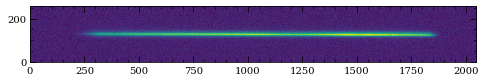

In [18]:
plt.imshow(d['im_slope_sim'][1000:1050,500:580])

In [18]:
d['im_slope_sim'] = im_fix = bp_fix(d['im_slope_sim'], in_place=True, sigclip=5, niter=3, verbose=True)

Bad Pixels fixed: 2105
Bad Pixels fixed: 35
Bad Pixels fixed: 9


In [20]:
im1, im2 = (d['im_slope_ideal'], d['im_slope_sim'])
hdu = fits.PrimaryHDU([im1,im2])

fname = 'pynrc_F322W2_ice_nvr_EOL{:.2f}_L+42.fits'.format(d['nc_scale'])
hdu.writeto(outdir + fname, overwrite=True)

# Analysis

In [19]:
figdir = 'figures_20200915/'

In [20]:
obs = d['obs']
im_wave = d['wave']
im_noise = d['im_slope_sim'] #d['im_slope_noise']

In [21]:
# Extract spectrum and flip
ymed = np.median(im_noise, axis=1)
indy = np.where(ymed==ymed.max())[0][0]
print(indy)

yext_size = 51
y1 = indy - int(yext_size/2)
y2 = y1 + yext_size
spec_extract = im_noise[y1:y2,:].sum(axis=0)[::-1]

w_true = im_wave[y1:y2,:].mean(axis=0)[::-1]

126


Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean             stddev     
    ------------------ ----------------- -----------------
    274.91507318219317 126.5486526644417 6.949953585562196


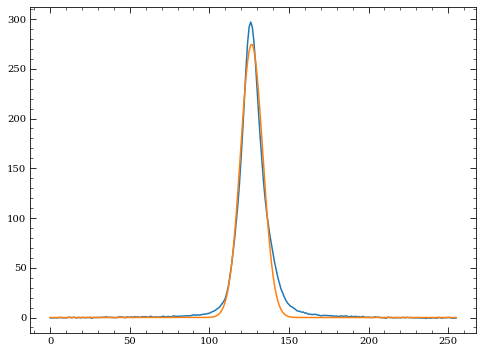

In [22]:
# Get width of Gaussian
from astropy.modeling import models, fitting

yvals = np.arange(im_noise.shape[0])

g_init = models.Gaussian1D(amplitude=ymed.max(), mean=yvals.max()/2, stddev=10.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, yvals, ymed)

plt.plot(yvals, ymed)
plt.plot(yvals, g(yvals), label='Gaussian')

print(g)

psf_sig_pix = g.stddev.value

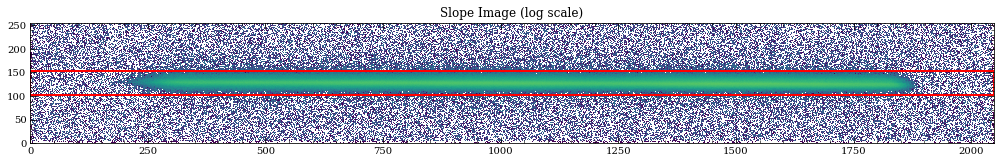

In [23]:
fig, ax = plt.subplots(1,1, figsize=(14,2.5))
#axes = axes.flatten()

#ax = axes[0]
ax.imshow(np.log10(im_noise), vmin=0, vmax=3.5)
ax.set_title('Slope Image (log scale)')

from matplotlib.patches import Rectangle
rect = Rectangle((0, y1+1), 2048, y2-y1+1, linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)

#ax = axes[1]
#ax.imshow(im_wave)

fig.tight_layout()
fig.savefig(figdir + 'imspsec.pdf')

## Guess wavelength solution

In [24]:
str_um = '$\mu \mathrm{m}$'

In [25]:
bp = pynrc.read_filter('F322W2', pupil='GRISM0', nc_scale=0, ote_scale=0)

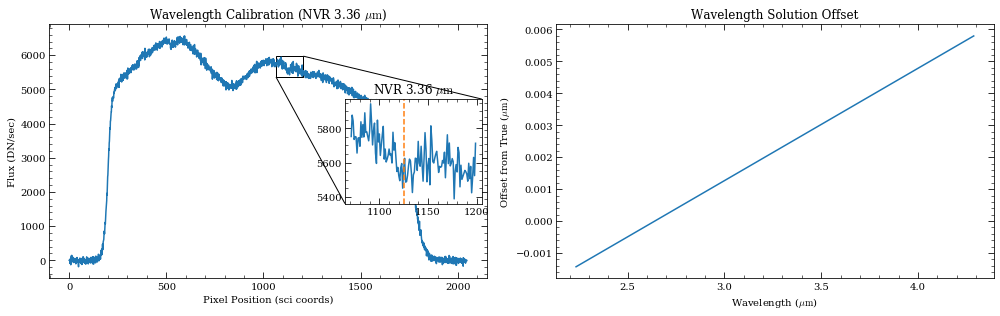

In [26]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset


xvals = np.arange(len(spec_extract))

xind = 1125
w_guess = np.arange(len(spec_extract))*0.001
w_guess += (3.36 - w_guess[xind])

fig, axes = plt.subplots(1,2, figsize=(14,4.5))

ax = axes[0]
ax.plot(xvals, spec_extract)

ax.set_title('Wavelength Calibration (NVR 3.36 {})'.format(str_um))
ax.set_xlabel('Pixel Position (sci coords)')
ax.set_ylabel('Flux (DN/sec)')

axins = zoomed_inset_axes(ax, 5, loc='center right') # zoom-factor: 2.5
mark_inset(ax, axins, loc1=3, loc2=1)#, fc="none", ec="0.5")
axins.set_title('NVR 3.36 {}'.format(str_um))
ind = (xvals>1070) & (xvals<1200)
axins.plot(xvals[ind], spec_extract[ind])
ylim = axins.get_ylim()
axins.plot([xind,xind], ylim, ls='--')
axins.set_ylim(ylim)


ax = axes[1]
ax.plot(w_true, (w_true - w_guess))


ax.set_title('Wavelength Solution Offset')
ax.set_xlabel('Wavelength ({})'.format(str_um))
ax.set_ylabel('Offset from True ({})'.format(str_um))

fig.tight_layout()
fig.savefig(figdir+'wavecal.pdf')

## Ice and NVR absorption models

In [27]:
def nc_eol_model(ice_thick=0.05, nvr_thick=0.189, wave=None):
    path = pynrc.conf.PYNRC_PATH

    fname = path + 'throughputs/h2o_abs.txt'
    names = ['Wave', 'coeff'] # coeff is per um path length
    data_ice  = ascii.read(fname, names=names)

    fname = path + 'throughputs/nvr_abs.txt'
    names = ['Wave', 'coeff'] # coeff is per um path length
    data_nvr  = ascii.read(fname, names=names)
    
    w_ice = data_ice['Wave']
    a_ice = data_ice['coeff']

    w_nvr = data_nvr['Wave']
    a_nvr = data_nvr['coeff']
    
    # Regrid to common wavelength
    if wave is None:
        wave = w_nvr
    else:
        a_nvr = np.interp(wave, w_nvr, a_nvr)
    a_ice = np.interp(wave, w_ice, a_ice)

    t_ice = np.exp(-a_ice*ice_thick)
    t_nvr = np.exp(-a_nvr*nvr_thick)
    t_nc = t_ice * t_nvr
    
    t_nc = np.exp(-a_ice*ice_thick-a_nvr*nvr_thick)
    
    return wave, t_nc

def ote_eol_model(wave=None):
    path = pynrc.conf.PYNRC_PATH
    fname = path + 'throughputs/ote_nc_sim_1.00.txt'
    names = ['Wave', 't_ice', 't_nvr', 't_sys']
    data  = ascii.read(fname, data_start=1, names=names)

    wtemp = data['Wave']
    wtemp = np.insert(wtemp, 0, [1.0]) # Estimates for w<2.5um
    wtemp = np.append(wtemp, [6.0])    # Estimates for w>5.0um
    
    ttemp = data['t_ice']
    ttemp = np.insert(ttemp, 0, [1.0]) # Estimates for w<2.5um
    ttemp = np.append(ttemp, [1.0])    # Estimates for w>5.0um
    
    if wave is None:
        wave = wtemp
        th = ttemp
    else:
        th = np.interp(wave, wtemp, ttemp)
    
    return wave, th

In [28]:
w_nc, t_nc  = nc_eol_model()
w_nc, t_ote = ote_eol_model(wave=w_nc)

In [29]:
path = pynrc.conf.PYNRC_PATH

fname = path + 'throughputs/h2o_abs.txt'
names = ['Wave', 'coeff'] # coeff is per um path length
data_ice  = ascii.read(fname, names=names)

fname = path + 'throughputs/nvr_abs.txt'
names = ['Wave', 'coeff'] # coeff is per um path length
data_nvr  = ascii.read(fname, names=names)

w_ice = data_ice['Wave']
a_ice = data_ice['coeff']

w_nvr = data_nvr['Wave']
a_nvr = data_nvr['coeff']

w_abs = w_nvr
a_ice = np.interp(w_abs, w_ice, a_ice)

In [30]:
from scipy import optimize
from astropy.convolution import Gaussian1DKernel, convolve

g = Gaussian1DKernel(stddev=psf_sig_pix)
a_ice_conv = convolve(np.interp(w_guess, w_abs, a_ice), g)
a_nvr_conv = convolve(np.interp(w_guess, w_abs, a_nvr), g)

def abs_func(x, p):
    t_abs_conv = np.exp(-p[0]*a_ice_conv - p[1]*a_nvr_conv)
    return np.interp(x, w_guess, t_abs_conv)

def cont_abs_func(x, p):
    t_abs_conv = np.exp(-p[-2]*a_ice_conv - p[-1]*a_nvr_conv)
    t_abs_conv = np.interp(x, w_guess, t_abs_conv)
    return jl_poly(x, p[0:-2])*t_abs_conv


def abs_func2(x, p):
    t_abs = np.exp(p[0]*np.log(t_ote) + p[1]*np.log(t_nc))    
    return np.interp(x, w_nc, t_abs)

def fit_bootstrap(pinit, datax, datay, function, yerr_systematic=0.0, nrand=1000, return_more=False):
    """Bootstrap fitting routine
    
    Bootstrap fitting algorithm to determine the uncertainties on the fit parameters.
    
    Parameters
    ----------
    pinit : ndarray
        Initial guess for parameters to fit
    datax, datay : ndarray
        X and y values of data to be fit
    function : func
        Model function 
    yerr_systematic : float or array_like of floats
        Systematic uncertainites on contributing to additional error in data. 
        This is treated as independent Normal error on each data point.
        Can have unique values for each data point. If 0, then we just use
        the standard deviation of the residuals to randomize the data.
    nrand : int
        Number of random data sets to generate and fit.
    return_all : bool
        If true, then also return the full set of fit parameters for the randomized
        data to perform a more thorough analysis of the distribution. Otherewise, 
        just reaturn the mean and standard deviations.
    """

#     errfunc = lambda p, x, y: function(x,p) - y
    def errfunc(p, x, y):
        return function(x, p) - y

    # Parameter limits
    lim_min = len(pinit) * [-np.inf]
    lim_max = len(pinit) * [np.inf]
    lim_min[-2] = 0
    lim_min[-1] = 0
    bounds = (lim_min, lim_max)
    
    # Fit first time
    #pfit, perr = optimize.leastsq(errfunc, pinit, args=(datax, datay), full_output=0)    
    res = optimize.least_squares(errfunc, pinit, args=(datax, datay), loss='huber', f_scale=0.1, bounds=bounds)
    pinit = res.x
    res = optimize.least_squares(errfunc, pinit, args=(datax, datay), loss='huber', f_scale=0.1, bounds=bounds)
    pfit = res.x


    if (nrand is not None) and (nrand>0):
        # Get the stdev of the residuals
        residuals = errfunc(pfit, datax, datay)
        sigma_res = np.std(residuals)

        sigma_err_total = np.sqrt(sigma_res**2 + yerr_systematic**2)

        # Some random data sets are generated and fitted
        randomdataY = datay + np.random.normal(scale=sigma_err_total, size=(nrand, len(datay)))
        ps = []
        for i in range(nrand):

    #         randomDelta = np.random.normal(0., sigma_err_total, len(datay))
    #         datay_rand = datay + randomDelta

            datay_rand = randomdataY[i]
            #randomfit, randomcov = optimize.leastsq(errfunc, pinit, args=(datax, datay_rand), full_output=0)
            res = optimize.least_squares(errfunc, pinit, args=(datax, datay_rand), 
                                         loss='huber', f_scale=0.1, bounds=bounds)
            randomfit = res.x

            ps.append(randomfit) 

        ps = np.array(ps)
        mean_pfit = np.mean(ps,axis=0)
        err_pfit = np.std(ps,axis=0)

        if return_more:
            return mean_pfit, err_pfit, ps
        else:
            return mean_pfit, err_pfit
        
    else:
        return pfit

In [31]:
def extract_ew(datax, datay):
    """Measure EW
    
    Extract equivalent width from continuum normalized spectrum
    
    Parameters
    ----------
    datax, datay : ndarray
        X and y values of data to be measured
    """
    
    ind_ew_tot = (datax>=2.6) & (datax<=3.8)
    ind_ew_3   = (datax>=2.6) & (datax<=3.3)
    ind_ew_nvr = (datax>=3.3) & (datax<=3.8)

    dw = datax[1]-datax[0]
    #model = abs_func(datax, pfit)
    #diff = spec_norm - model

    ew_all = []
    for ind in [ind_ew_tot, ind_ew_3, ind_ew_nvr]:
        ew_all.append(np.sum(1 - datay[ind])*dw * 1e4)
    ew_all = np.array(ew_all)

    return ew_all


In [32]:
def fit_all(pinit, datax, datay, function):
    
    def errfunc(p, x, y):
        return function(x, p) - y

    # Parameter limits
    lim_min = len(pinit) * [-np.inf]
    lim_max = len(pinit) * [np.inf]
    lim_min[-2] = 0
    lim_min[-1] = 0
    bounds = (lim_min, lim_max)
    
    # Fit first time
    #pfit, perr = optimize.leastsq(errfunc, pinit, args=(datax, datay), full_output=0)    
    res = optimize.least_squares(errfunc, pinit, args=(datax, datay), loss='huber', f_scale=0.1, bounds=bounds)
    pinit = res.x
    res = optimize.least_squares(errfunc, pinit, args=(datax, datay), loss='huber', f_scale=0.1, bounds=bounds)
    pfit = res.x


(2.8, 3.6)

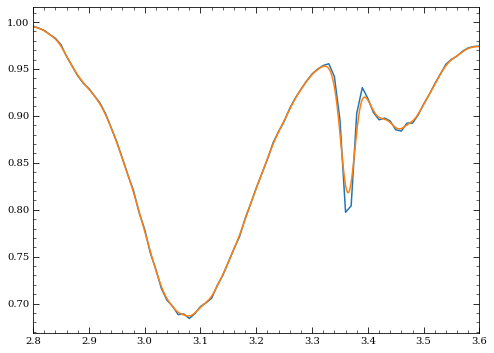

In [33]:
plt.plot(w_abs, np.exp(-0.5*a_nvr))
plt.plot(w_guess, np.exp(-0.5*a_nvr_conv))

plt.xlim([2.8,3.6])

## Analysis: Normalize by Bandpass & G2V Template

In [34]:
bp_k = pynrc.bp_2mass('k')
kmag = 10
sp_norm = pynrc.stellar_spectrum('G5V', kmag, 'vegamag', bp_k)
sp_norm.convert('photlam')

bp = pynrc.read_filter('F322W2', pupil='GRISM0', ote_scale=0, nc_scale=0)

In [35]:
sp_val = np.interp(w_guess, sp_norm.wave/1e4, sp_norm.flux)
bp_val = np.interp(w_guess, bp.wave/1e4, bp.throughput)

# Normalized value convolved with Gaussian
norm_val = sp_val*bp_val
g = Gaussian1DKernel(stddev=psf_sig_pix)
norm_val_conv = convolve(norm_val, g)

spec_corr = spec_extract / norm_val_conv

In [36]:
# Cut off edges and normalize at continuum location
ind = (w_guess>2.45) & (w_guess<3.95)
wind = w_guess[ind]
spec_fin = spec_corr[ind]
spec_fin /= np.median(spec_fin[wind<2.8])

In [37]:
w = wind
# Indices to fit continuum
ind_fit = ((w>=2.6) & (w<=2.75)) | ((w>=3.8) & (w<=3.95))
yerr_sys = 0.05

In [38]:
# Fit water ice and NVR thicknesses (um)
deg_arr = np.array([1,2,3])#,4,5])
chi_arr = []
for deg in deg_arr:

    cf = jl_poly_fit(w[ind_fit], spec_fin[ind_fit], deg=deg, robust_fit=True)
    spec_cont = jl_poly(w, cf)
    spec_norm = spec_fin / spec_cont
    
    pinit = [0.001,0.001]
    ifit = (w>2.8) & (w<3.6)

    wfit = wind[ifit]
    sfit = spec_norm[ifit]
    pfit, perr, pfit_all = fit_bootstrap(pinit, wfit, sfit, abs_func, nrand=100, 
                                         yerr_systematic=yerr_sys, return_more=True)
    
    model = abs_func(wfit, pfit)
    chi = np.sum((sfit - model)**2 / model)
    chi_arr.append(chi)
    
    print(deg, chi, pfit)
    
chi_arr = np.array(chi_arr)

1 0.10199233346058183 [0.05084403 0.16475665]
2 0.1305064111893945 [0.04700417 0.1976531 ]
3 0.1339229747355204 [0.04355372 0.20588174]


In [39]:
# Fit water ice and NVR thicknesses (um)

# Choose degree of polynomial that provides the best fit
deg = deg_arr[chi_arr==np.min(chi_arr)][0]
# deg=2

cf = jl_poly_fit(w[ind_fit], spec_fin[ind_fit], deg=deg, robust_fit=True)
spec_cont = jl_poly(w, cf)
spec_norm = spec_fin / spec_cont

pinit = [0.001,0.001]
ifit = (w>2.8) & (w<3.6)

wfit = w[ifit]
sfit = spec_norm[ifit]
pfit, perr, pfit_all = fit_bootstrap(pinit, wfit, sfit, abs_func, nrand=100, 
                                     yerr_systematic=yerr_sys, return_more=True)

print(pfit, perr)

[0.05107881 0.16453632] [0.00447601 0.01099243]


In [40]:
print("Ice Layer = {:4.0f} +/- {:3.0f} A".format(pfit[0]*1e4, perr[0]*1e4))
print("NVR Layer = {:4.0f} +/- {:3.0f} A".format(pfit[1]*1e4, perr[1]*1e4))

Ice Layer =  511 +/-  45 A
NVR Layer = 1645 +/- 110 A


In [41]:
model = abs_func(wind, pfit)

ew_nom = extract_ew(wind, model)
print(ew_nom)

[639.03915828 540.63524935  98.63134938]


In [42]:
# Randomize throughput curve
nrand = 1000

t = w_guess - w_guess.min()
t /= t.max()
t = t + np.random.random_sample(size=nrand).reshape([-1,1])
t = t * (2*np.pi) * 10*np.random.random_sample(size=nrand).reshape([-1,1])
ns = np.random.normal(loc=1, scale=0.05, size=nrand).reshape([-1,1]) + \
        np.random.normal(loc=0.03, scale=0.005, size=nrand).reshape([-1,1]) * \
        np.sin(t)

th_new = bp_val * ns

# Normalize extracted spectrum by spectral template and throughput curve
norm_val_all = sp_val * th_new
norm_val_conv_all = np.array([convolve(val, g) for val in norm_val_all])
spec_corr_all = spec_extract / norm_val_conv_all

# Cut off edges and normalize at continuum location
ind = (w_guess>2.45) & (w_guess<3.95)
wind = w_guess[ind]
spec_fin_all = spec_corr_all[:,ind]
spec_fin_all = spec_fin_all / np.median(spec_fin_all[:,wind<2.8], axis=1).reshape([-1,1])

# Fit continuum as first guess
deg=3
ind_fit = ((wind>=2.6) & (wind<=2.75)) | ((wind>=3.8) & (wind<=3.95))
cf_all = jl_poly_fit(wind[ind_fit], spec_fin_all[:,ind_fit].transpose(), deg=deg, robust_fit=True)

# Better fitting function
cf_cont_all = []
cf_abs_all = []
for i in trange(nrand):
    pinit = list(cf_all[:,i]) + [0.001, 0.001]
    res = fit_bootstrap(pinit, wind, spec_fin_all[i], cont_abs_func, nrand=0)
    cf_cont_all.append(res[:-2])
    cf_abs_all.append(res[-2:])
cf_cont_all = np.array(cf_cont_all)
cf_abs_all = np.array(cf_abs_all)

# Remove continuum
cont_all = jl_poly(wind, cf_cont_all.transpose(), dim_reorder=True)
spec_norm_all = spec_fin_all / cont_all

# Absorption models
abs_model_all = np.array([abs_func(wind, pfit) for pfit in cf_abs_all])

[639.36372445 543.80954229  95.7337326 ]
[75.51057148 59.0233023  35.4070595 ]


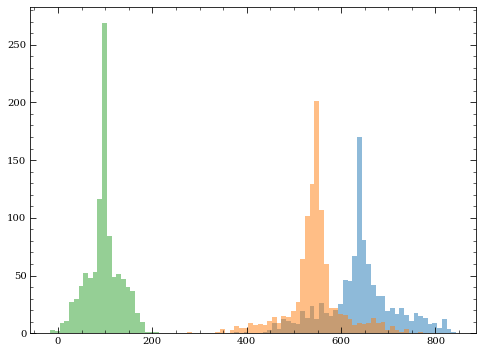

In [44]:
ew_all = np.array([extract_ew(wind, val) for val in spec_norm_all])
ew_med = np.median(ew_all, axis=0)
ew_std = np.std(ew_all, axis=0)

print(np.median(ew_all, axis=0))
print(np.std(ew_all, axis=0))

bins = np.arange(np.min(ew_all), np.max(ew_all), 10)
_ = plt.hist(ew_all[:,0], bins=bins, alpha=0.5)
_ = plt.hist(ew_all[:,1], bins=bins, alpha=0.5)
_ = plt.hist(ew_all[:,2], bins=bins, alpha=0.5)

In [53]:
abs_model_all.shape

(1000, 1499)

In [51]:
cf_abs_all.shape

(1000, 2)

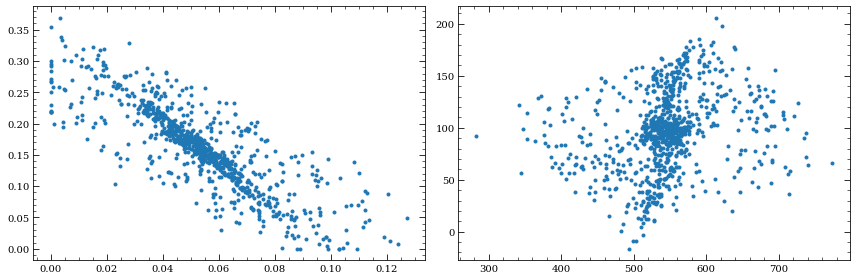

In [70]:
# Plot covariance between parameter fits
fig, axes = plt.subplots(1,2, figsize=(12,4))

ax = axes[0]
x, y = cf_abs_all[:,0], cf_abs_all[:,1]
ax.plot(x, y, marker='.', ls='none')

ax = axes[1]
x, y = ew_all[:,1], ew_all[:,2]
ax.plot(x, y, marker='.', ls='none')

fig.tight_layout()

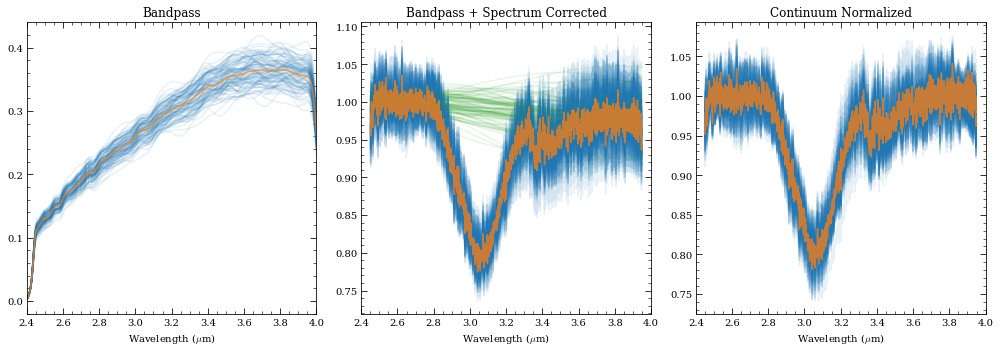

In [45]:
fig, axes = plt.subplots(1,3, figsize=(14,5))

for val in th_new[0:100]:
    axes[0].plot(w_guess, val, alpha=0.1, color='C0')

for i, val in enumerate(spec_fin_all[0:100]):
    axes[1].plot(wind, val, alpha=0.1, color='C0', rasterized=True)
    axes[1].plot(wind, cont_all[i,:], alpha=0.1, color='C2')
    
for val in spec_norm_all[0:100]:
    axes[2].plot(wind, val, alpha=0.1, color='C0', rasterized=True)

    
axes[0].plot(bp.wave/1e4, bp.throughput, color='C1', alpha=0.75)
axes[1].plot(wind, spec_fin, color='C1', alpha=0.75)
axes[2].plot(wind, spec_norm, color='C1', alpha=0.75)

for ax in axes:
    ax.set_xlabel('Wavelength ($\mu$m)')
    ax.set_xlim([2.4,4.0])
    ax.xaxis.get_major_locator().set_params(nbins=10, steps=[1, 2, 5, 10])
    
axes[0].set_title("Bandpass")
axes[1].set_title("Bandpass + Spectrum Corrected")
axes[2].set_title("Continuum Normalized")

fig.tight_layout()
fig.savefig(figdir+'error_spectra.pdf')
fig.savefig(figdir+'error_spectra.png')

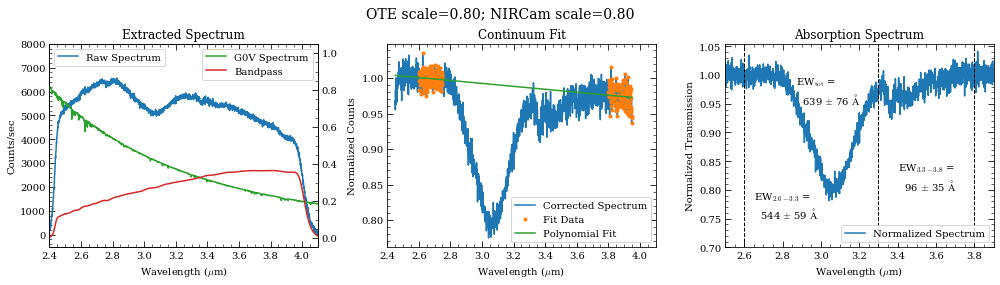

In [46]:
fig, axes = plt.subplots(1,3, figsize=(14,4))

ax = axes[0]
ax.plot(w_guess, spec_extract, label='Raw Spectrum')
ax.set_title('Extracted Spectrum')
ax.set_ylabel('Counts/sec')

ax2 = axes[0].twinx()
ax2.plot(w_guess, sp_val/sp_val.max(), color='C2', label='G0V Spectrum')
ax2.plot(bp.wave/1e4, bp.throughput, color='C3', label = 'Bandpass')
#ax2.set_ylabel('Throughput')

ax.set_ylim(ax.get_ylim()[0], 8000)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')


ax = axes[1]
ax.plot(wind, spec_fin, label='Corrected Spectrum')
ax.plot(wind[ind_fit], spec_fin[ind_fit], marker='.', ls='none', label='Fit Data')
ax.plot(wind, spec_cont, label='Polynomial Fit')
ax.set_title('Continuum Fit')
ax.set_ylabel('Normalized Counts')
ax.legend()


ax = axes[2]
ax.plot(wind, spec_norm, label='Normalized Spectrum')
ylim2 = [0.70, ax.get_ylim()[1]]
for xv in [2.6,3.3,3.8]:
    ax.plot([xv,xv], ylim2, ls='--', lw=1, color='k')
ax.set_title('Absorption Spectrum')
ax.set_ylabel('Normalized Transmission')

#label='Water = {:4.0f} $\pm$ {:3.0f} A'.format(pfit[0]*1e4, perr[0]*1e4)
#ax.plot(wind, abs_func(wind, [pfit[0], 0]), label=label)
#label='NVR   = {:4.0f} $\pm$ {:3.0f} A'.format(pfit[1]*1e4, perr[1]*1e4)
#ax.plot(wind, abs_func(wind, [0, pfit[1]]), label=label)
#ax.plot(wind, abs_func(wind, pfit), label='Total Absorption')
#ax.plot(wind, abs_func2(wind, pfit2))
ax.set_ylim([ax.get_ylim()[0],1.05])
ax.legend(loc='lower right')

txt_vals = ' {:.0f} $\pm$ {:.0f}'.format(ew_med[0], ew_std[0]) 
ax.text(2.87, 0.95, 'EW$_\mathrm{tot}$ =\n ' + txt_vals + ' $\mathrm{\AA}$')
txt_vals = ' {:.0f} $\pm$ {:.0f}'.format(ew_med[1], ew_std[1]) 
ax.text(2.65, 0.75, 'EW$_{2.6-3.3}$ =\n ' + txt_vals + ' $\mathrm{\AA}$')
txt_vals = ' {:.0f} $\pm$ {:.0f}'.format(ew_med[2], ew_std[2]) 
ax.text(3.4, 0.8, 'EW$_{3.3-3.8}$ =\n ' + txt_vals + ' $\mathrm{\AA}$')


for ax in axes:
    ax.set_xlabel('Wavelength ($\mu$m)')
    ax.set_xlim([2.4,4.1])
    ax.xaxis.get_major_locator().set_params(nbins=10, steps=[1, 2, 5, 10])

axes[2].set_xlim([2.5,3.9])
axes[2].set_ylim(ylim2)
    

    
fig.suptitle('OTE scale={:.2f}; NIRCam scale={:.2f}'.format(d['ote_scale'],d['nc_scale']), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

fig.savefig(figdir+'fit_bpspcorr_ote{:.2f}_nc{:.2f}_EW.pdf'.format(d['ote_scale'],d['nc_scale']))

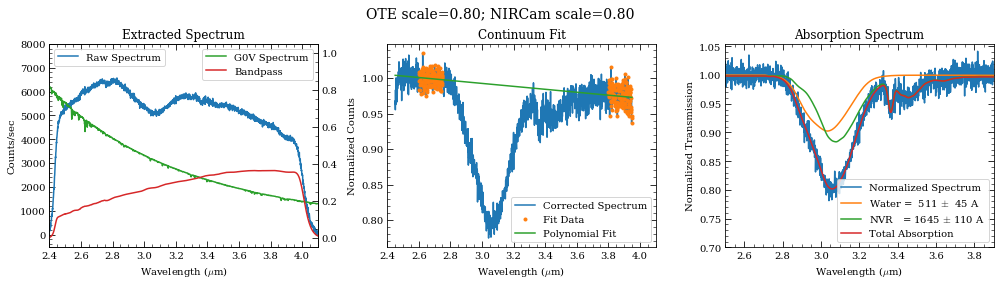

In [47]:
fig, axes = plt.subplots(1,3, figsize=(14,4))

ax = axes[0]
ax.plot(w_guess, spec_extract, label='Raw Spectrum')
ax.set_title('Extracted Spectrum')
ax.set_ylabel('Counts/sec')

ax2 = axes[0].twinx()
ax2.plot(w_guess, sp_val/sp_val.max(), color='C2', label='G0V Spectrum')
ax2.plot(bp.wave/1e4, bp.throughput, color='C3', label = 'Bandpass')
#ax2.set_ylabel('Throughput')

ax.set_ylim(ax.get_ylim()[0], 8000)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')


ax = axes[1]
ax.plot(wind, spec_fin, label='Corrected Spectrum')
ax.plot(wind[ind_fit], spec_fin[ind_fit], marker='.', ls='none', label='Fit Data')
ax.plot(wind, spec_cont, label='Polynomial Fit')
ax.set_title('Continuum Fit')
ax.set_ylabel('Normalized Counts')
ax.legend()


ax = axes[2]
ax.plot(wind, spec_norm, label='Normalized Spectrum')
ylim2 = [0.70, ax.get_ylim()[1]]

ax.set_title('Absorption Spectrum')
ax.set_ylabel('Normalized Transmission')

label='Water = {:4.0f} $\pm$ {:3.0f} A'.format(pfit[0]*1e4, perr[0]*1e4)
ax.plot(wind, abs_func(wind, [pfit[0], 0]), label=label)
label='NVR   = {:4.0f} $\pm$ {:3.0f} A'.format(pfit[1]*1e4, perr[1]*1e4)
ax.plot(wind, abs_func(wind, [0, pfit[1]]), label=label)
ax.plot(wind, abs_func(wind, pfit), label='Total Absorption')
#ax.plot(wind, abs_func2(wind, pfit2))
ax.set_ylim([ax.get_ylim()[0],1.05])
ax.legend(loc='lower right')


for ax in axes:
    ax.set_xlabel('Wavelength ($\mu$m)')
    ax.set_xlim([2.4,4.1])
    ax.xaxis.get_major_locator().set_params(nbins=10, steps=[1, 2, 5, 10])

axes[2].set_xlim([2.5,3.9])
axes[2].set_ylim(ylim2)
    
fig.suptitle('OTE scale={:.2f}; NIRCam scale={:.2f}'.format(d['ote_scale'],d['nc_scale']), fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85)

fig.savefig(figdir+'fit_bpspcorr_ote{:.2f}_nc{:.2f}.pdf'.format(d['ote_scale'],d['nc_scale']))

In [72]:
ind_ew_tot = (wind>=2.6) & (wind<=3.8)
ind_ew_3   = (wind>=2.6) & (wind<=3.3)
ind_ew_nvr = (wind>=3.3) & (wind<=3.8)

dw = wind[1]-wind[0]
model = abs_func(wind, pfit)
diff = spec_norm - model

ew_all = []
_ew_all = []
for ind in [ind_ew_tot, ind_ew_3, ind_ew_nvr]:
    ew_all.append(np.sum(1 - model[ind])*dw * 1e4)
    _ew_all.append(np.sqrt(len(ind)) * np.std(diff[ind]))

In [74]:
# Scale = 0.8
print("EWs (A):", ew_all)
print("Uncertainties:", _ew_all)
print("Tmin:", model.min())

EWs (A): [638.3452773715528, 555.3543633088108, 83.19639140021086]
Uncertainties: [0.3172428267360476, 0.29718160329814475, 0.32905571433949454]
Tmin: 0.7979805304929093


In [420]:
from astropy.table import Table

bp.wave
t = Table([bp.wave/1e4, bp.throughput], names=('Wave', 'Throughput'))

t['Wave'].info.format = '10.6f'
t['Throughput'].info.format = '10.6f'

# Save to disk
t.write(figdir+bp.name+'.dat', format='ascii')

In [ ]:
im1, im2 = (d['im_slope_ideal'], d['im_slope_sim'])
hdu = fits.PrimaryHDU([im1,im2])

fname = 'pynrc_F322W2_ice_nvr_EOL0.8_L+89.fits'
hdu.writeto(outdir + fname)

In [ ]:
im1, im2 = (d['im_slope_ideal'], d['im_slope_sim'])
hdu = fits.PrimaryHDU([im1,im2])

fname = 'slope_im{}.fits'.format(key)
hdu.writeto(outdir + fname)

In [ ]:
outdir = 'slope_images_20190717/'
ice_vals = [0.3, 1.5, 0.9, 0, 0.5]

key = keys[-1]
d = obs_dict[key]
for i, ice in enumerate(ice_vals):

    
    update_obs_dict(obs_dict, key, ice_scale=ice, nvr_scale=0)
    im1, im2 = (d['im_slope_ideal'], d['im_slope_sim'])
    hdu = fits.PrimaryHDU([im1,im2])
    
    fname = 'slope_im{}.fits'.format(i)
    hdu.writeto(outdir + fname)
    
